In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchsummary import summary

In [ ]:
base_path = "images"
rgb_path = os.path.join(base_path, "rgb")
seg_path = os.path.join(base_path, "seg")


IMG_HEIGHT = 384
IMG_WIDTH = 384
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, image_size=(84, 84)):
        self.folder_path = folder_path
        self.image_size = image_size
        self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]
        
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.Grayscale(num_output_channels=1),  # Ensure single-channel input
            transforms.ToTensor(),
        ])
        
        # Preload all images into memory as tensors
        self.images = []
        
        for image_path in tqdm(self.image_paths, desc="Converting Images to Tensors"):
            image = Image.open(image_path)
            image = self.transform(image)
            self.images.append(image)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return self.images[idx]
        # image_path = self.image_paths[idx]
        # image = Image.open(image_path)
        # image = self.transform(image)
        # return image

In [4]:
# Usage
folder_path = "images/seg"
dataset = ImageDataset(folder_path)

# Split dataset into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Converting Images to Tensors:   0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   #(1, 84, 84) -> (16, 84, 84)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  #(16, 84, 84) -> (16, 42, 42)
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=0),   #(16, 42, 42) -> (8, 40, 40)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  #(8, 40, 40) -> (8, 20, 20)
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),    #(8, 20, 20) -> (8, 20, 20)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   #(8, 20, 20) -> (8, 10, 10)
        )

        self.fc_enc = nn.Sequential(
            nn.Linear(4*10*10, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc_enc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc_dec = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 4*10*10),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.Sigmoid() # No need for Sigmoid as we are using BCEWithLogitsLoss
        )

    def forward(self, x):
        x = self.fc_dec(x)
        x = x.view(x.size(0), 4, 10, 10)
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

# an example input->output dim check
model = Autoencoder().to(DEVICE)
summary(model, (1, 84, 84), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 84, 84]             160
              ReLU-2           [-1, 16, 84, 84]               0
         MaxPool2d-3           [-1, 16, 42, 42]               0
            Conv2d-4            [-1, 8, 40, 40]           1,160
              ReLU-5            [-1, 8, 40, 40]               0
         MaxPool2d-6            [-1, 8, 20, 20]               0
            Conv2d-7            [-1, 4, 20, 20]             292
              ReLU-8            [-1, 4, 20, 20]               0
         MaxPool2d-9            [-1, 4, 10, 10]               0
           Linear-10                  [-1, 512]         205,312
             ReLU-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
             ReLU-13                  [-1, 256]               0
          Encoder-14                  [

In [83]:
# Initialize the autoencoder
model = Autoencoder().to(DEVICE)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

tensor(0.9086)


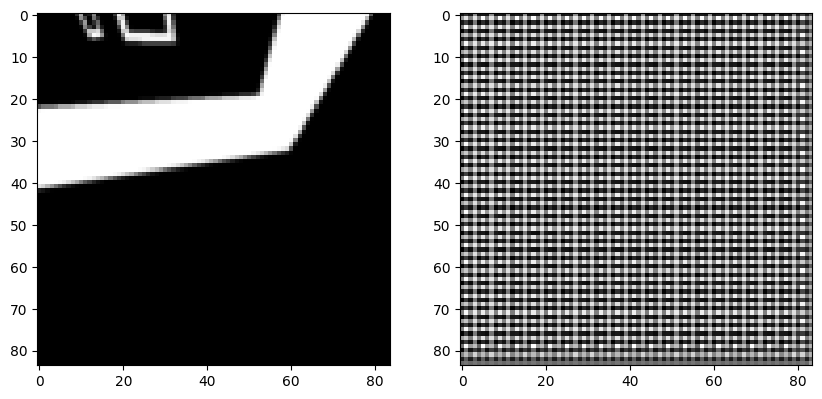

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for data in train_dataloader:
    img = data
    ax[0].imshow(img[0].cpu().squeeze().numpy(), cmap='gray')
    img = F.sigmoid(model(img.to(DEVICE))).cpu().detach()
    print(criterion(img, data))
    ax[1].imshow(img[0].squeeze().numpy(), cmap='gray')
    break

# Train

In [87]:
# Training autoencoder
EPOCHS = 50
for epoch in range(EPOCHS):
    avg_loss = 0
    for data in train_dataloader:
        img = data.to(DEVICE)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('\tTrain Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, avg_loss/len(train_dataloader)))
    
    if epoch % 10 == 0:
        avg_loss = 0
        with torch.no_grad():
            for data in test_dataloader:
                img = data
                img = img.to(DEVICE)
                output = model(img)
                loss = criterion(output, img)
                avg_loss += loss.item()
            print('Test Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, avg_loss/len(test_dataloader)))

# Save the model
torch.save(model.state_dict(), './models/encoder.pth')

	Train Epoch [1/50], Loss: 0.1132
Test Epoch [1/50], Loss: 0.1224
	Train Epoch [2/50], Loss: 0.1129
	Train Epoch [3/50], Loss: 0.1130
	Train Epoch [4/50], Loss: 0.1120
	Train Epoch [5/50], Loss: 0.1121
	Train Epoch [6/50], Loss: 0.1117
	Train Epoch [7/50], Loss: 0.1116
	Train Epoch [8/50], Loss: 0.1109
	Train Epoch [9/50], Loss: 0.1105
	Train Epoch [10/50], Loss: 0.1112
	Train Epoch [11/50], Loss: 0.1105
Test Epoch [11/50], Loss: 0.1179
	Train Epoch [12/50], Loss: 0.1097
	Train Epoch [13/50], Loss: 0.1103
	Train Epoch [14/50], Loss: 0.1094
	Train Epoch [15/50], Loss: 0.1095
	Train Epoch [16/50], Loss: 0.1091
	Train Epoch [17/50], Loss: 0.1088
	Train Epoch [18/50], Loss: 0.1093
	Train Epoch [19/50], Loss: 0.1089
	Train Epoch [20/50], Loss: 0.1086
	Train Epoch [21/50], Loss: 0.1082
Test Epoch [21/50], Loss: 0.1153
	Train Epoch [22/50], Loss: 0.1081
	Train Epoch [23/50], Loss: 0.1081
	Train Epoch [24/50], Loss: 0.1080
	Train Epoch [25/50], Loss: 0.1078
	Train Epoch [26/50], Loss: 0.1076
	

# Compare

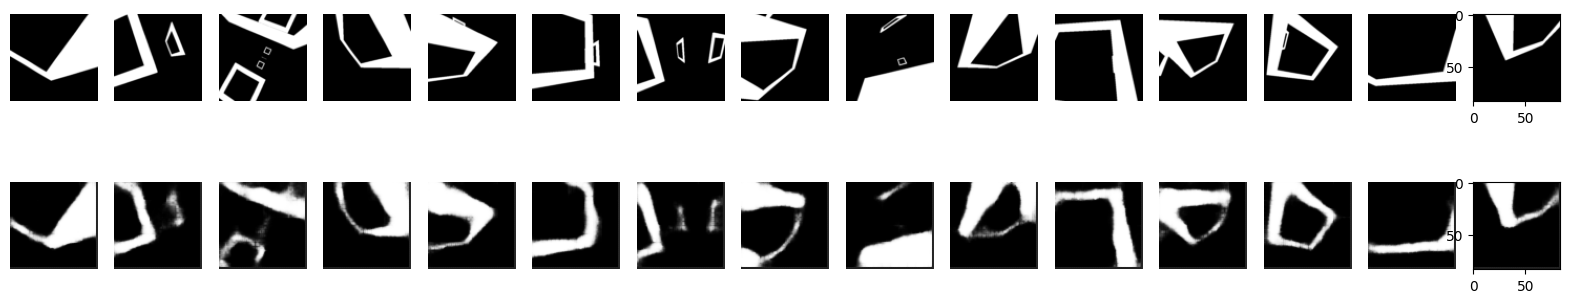

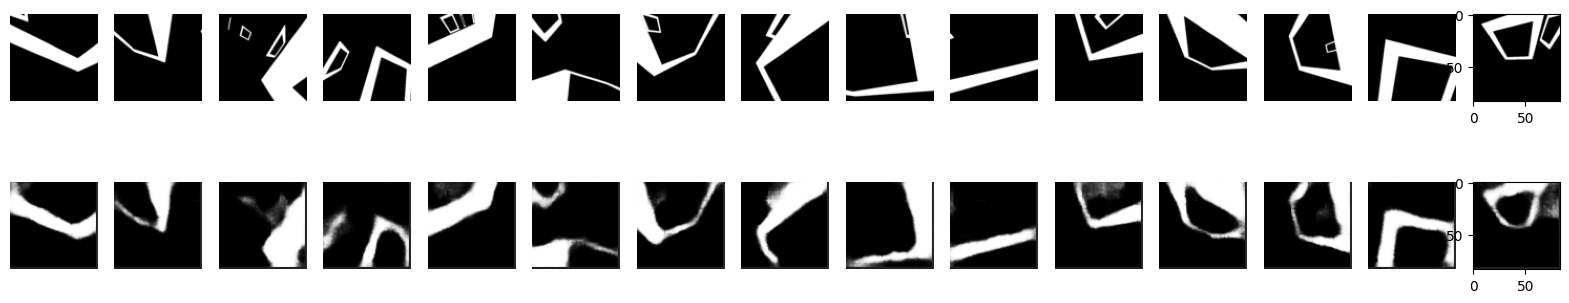

In [111]:
fig, ax = plt.subplots(2, 15, figsize=(20, 4))
for i, data in enumerate(train_dataloader):
    img = data
    ax[0, i].imshow(img[0].cpu().squeeze().numpy(), cmap="gray")
    img = F.sigmoid(model(img.to(DEVICE))).cpu().detach()
    ax[1, i].imshow(img[0].squeeze().numpy(), cmap="gray")
    if i >= 14:
        break
    ax[0,i].axis('off')
    ax[1,i].axis('off')


fig, ax = plt.subplots(2, 15, figsize=(20, 4))
for i, data in enumerate(test_dataloader):
    img = data
    ax[0, i].imshow(img[0].cpu().squeeze().numpy(), cmap="gray")
    img = F.sigmoid(model(img.to(DEVICE))).cpu().detach()
    ax[1, i].imshow(img[0].squeeze().numpy(), cmap="gray")
    if i >= 14:
        break
    ax[0,i].axis('off')
    ax[1,i].axis('off')


# Save

In [ ]:
torch.save(model.encoder.state_dict(), './weights/encoder.pth')